# Pre-processing Century Deposit Data

Note: The preprocessing code is adapted from a SimPEG example authored by Lindsey Heagy and presented at Transform 2020. [Original Materials](https://curvenote.com/@simpeg/transform-2020-simpeg-tutorial/!6DDumb03Le6D8N8xuJNs)

This notebook cpatures the preprocessing of the dataset being used in [Century Data DCIP example](pygimli_century_dcip.ipynb). More specifically, the DC and IP data on line `46800E` are organized and stored into file `century_dcip_data.txt` with the following attributes:
- a_location
- b_location
- m_location
- n_location
- apparent resistivity
- apparent resistivity standard deviation
- apparent chargeability
- apparent chargeability standard deviation
- geometric_factor

## 1. Load the dataset

### 1.1. Download dataset and import modules

In [1]:
# download the dataset

!git clone https://github.com/simpeg/transform-2020-simpeg.git
%cd transform-2020-simpeg/

Cloning into 'transform-2020-simpeg'...


remote: Enumerating objects: 361, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (33/33), done.


remote: Total 361 (delta 18), reused 19 (delta 5), pack-reused 317
Receiving objects: 100% (361/361), 5.34 MiB | 13.46 MiB/s, done.


Resolving deltas: 100% (175/175), done.


/home/jiawen/test/cofi-examples/examples/pygimli_dcip/transform-2020-simpeg


In [2]:
import os
import shutil
import numpy as np

### 1.2. See what's in the data folder

In [3]:
# overview of dataset files/folders
os.listdir('century')

['27750N',
 '46800E',
 '46200E',
 'gmt',
 '47200E',
 '47000E',
 '47700E',
 'geologic_section.csv',
 'Data_in_3D_format']

In [4]:
# data files for the chosen line
line = "46800E"
os.listdir(os.path.join('century',line))

['46800IP.OBS',
 'IPMODA.CHG',
 '468MESH.DAT',
 '46800POT.OBS',
 'DCMODA.CON',
 'IPMODA.PRE',
 'DCMODA.PRE']

In [5]:
# files we are going to load
dc_data_file = f"./century/{line}/{line[:-1]}POT.OBS"
ip_data_file = f"./century/{line}/{line[:-1]}IP.OBS"

dc_data_file, ip_data_file

('./century/46800E/46800POT.OBS', './century/46800E/46800IP.OBS')

In [6]:
# copy geologic section data
shutil.copy("century/geologic_section.csv", "../century_geologic_section.csv")

'../century_geologic_section.csv'

In [7]:
# copy reference images
shutil.copy("images/Mutton-Figure1-1.png", "../Mutton-Figure1-1.png")
shutil.copy("images/Mutton-Figure2-1.png", "../Mutton-Figure2-1.png")

'../Mutton-Figure2-1.png'

### 1.3. Define utility loader function

In [8]:
# Utility load function - to be used for both DC and IP data files

def read_dcip_data(filename, verbose=True):
    """
    Read in a .OBS file from the Century data set into a python dictionary. 
    The format is the old UBC-GIF DCIP format.
    
    Parameters
    ----------
    filename : str
        Path to the file to be parsed
    
    verbose: bool
        Print some things? 
    
    
    Returns
    -------
    dict
        A dictionary with the locations of
        - a_locations: the positive source electrode locations (numpy array) 
        - b_locations: the negative source electrode locations (numpy array) 
        - m_locations: the receiver locations (list of numpy arrays)
        - n_locations: the receiver locations (list of numpy arrays)
        - observed_data: observed data (list of numpy arrays)
        - standard_deviations: assigned standard deviations (list of numpy arrays)
        - n_sources: number of sources (int)
    
    """
    
    # read in the text file as a numpy array of strings (each row is an entry)
    contents = np.genfromtxt(filename, delimiter=' \n', dtype=str)
    
    # the second line has the number of sources, current, and data type (voltages if 1)
    n_sources = int(contents[1].split()[0])
    
    if verbose is True: 
        print(f"number of sources: {n_sources}")
    
    # initialize storage for the electrode locations and data
    a_locations = np.zeros(n_sources)
    b_locations = np.zeros(n_sources)
    m_locations = []
    n_locations = []
    observed_data = []
    standard_deviations = []
    
    # index to track where we have read in content 
    content_index = 1 
    
    # loop over sources 
    for i in range(n_sources):
        # start by reading in the source info 
        content_index = content_index + 1  # read the next line
        a_location, b_location, nrx = contents[content_index].split()  # this is a string
        
        # convert the strings to a float for locations and an int for the number of receivers
        a_locations[i] = float(a_location)
        b_locations[i] = float(b_location)
        nrx = int(nrx)

        if verbose is True: 
            print(f"Source {i}: A-loc: {a_location}, B-loc: {b_location}, N receivers: {nrx}")

        # initialize space for receiver locations, observed data associated with this source
        m_locations_i, n_locations_i = np.zeros(nrx), np.zeros(nrx)
        observed_data_i, standard_deviations_i = np.zeros(nrx), np.zeros(nrx)

        # read in the receiver info 
        for j in range(nrx):
            content_index = content_index + 1  # read the next line
            m_location, n_location, datum, std = contents[content_index].split()

            # convert the locations and data to floats, and store them
            m_locations_i[j] = float(m_location)
            n_locations_i[j] = float(n_location)
            observed_data_i[j] = float(datum)
            standard_deviations_i[j] = float(std)

        # append the receiver info to the lists
        m_locations.append(m_locations_i)
        n_locations.append(n_locations_i)
        observed_data.append(observed_data_i)
        standard_deviations.append(standard_deviations_i)
    
    return {
        "a_locations": a_locations,
        "b_locations": b_locations, 
        "m_locations": m_locations,
        "n_locations": n_locations,
        "observed_data": observed_data, 
        "standard_deviations": standard_deviations,
        "n_sources": n_sources, 
    }

## 2. Apparent Resistivity

### 2.1. Load voltage data

In [9]:
dc_data_dict = read_dcip_data(dc_data_file)

number of sources: 27
Source 0: A-loc: 26000.000000, B-loc: 26100.000000, N receivers: 2
Source 1: A-loc: 26100.000000, B-loc: 26200.000000, N receivers: 3
Source 2: A-loc: 26200.000000, B-loc: 26300.000000, N receivers: 4
Source 3: A-loc: 26300.000000, B-loc: 26400.000000, N receivers: 5
Source 4: A-loc: 26400.000000, B-loc: 26500.000000, N receivers: 6
Source 5: A-loc: 26500.000000, B-loc: 26600.000000, N receivers: 7
Source 6: A-loc: 26600.000000, B-loc: 26700.000000, N receivers: 7
Source 7: A-loc: 26700.000000, B-loc: 26800.000000, N receivers: 6
Source 8: A-loc: 26800.000000, B-loc: 26900.000000, N receivers: 6
Source 9: A-loc: 26900.000000, B-loc: 27000.000000, N receivers: 6
Source 10: A-loc: 27000.000000, B-loc: 27100.000000, N receivers: 6
Source 11: A-loc: 27100.000000, B-loc: 27200.000000, N receivers: 6
Source 12: A-loc: 27200.000000, B-loc: 27300.000000, N receivers: 6
Source 13: A-loc: 27300.000000, B-loc: 27400.000000, N receivers: 6
Source 14: A-loc: 27400.000000, B-lo

### 2.2. See what's in voltage data

In [10]:
for key, value in dc_data_dict.items():
    print(f"{key:<20}: {type(value)}")

a_locations         : <class 'numpy.ndarray'>
b_locations         : <class 'numpy.ndarray'>
m_locations         : <class 'list'>
n_locations         : <class 'list'>
observed_data       : <class 'list'>
standard_deviations : <class 'list'>
n_sources           : <class 'int'>


In [11]:
dc_data_dict["a_locations"]

array([26000., 26100., 26200., 26300., 26400., 26500., 26600., 26700.,
       26800., 26900., 27000., 27100., 27200., 27300., 27400., 27500.,
       27600., 27700., 27800., 27900., 28000., 28100., 28200., 28300.,
       28400., 28500., 28600.])

In [12]:
# error of voltages in percentage
err = np.hstack(dc_data_dict["standard_deviations"]) / np.hstack(dc_data_dict["observed_data"])
err *= 100
np.min(err), np.max(err)

(-5.633802816901409, -4.49438202247191)

In [13]:
dc_data_dict["standard_deviations"]

[array([6.e-05, 4.e-05]),
 array([8.e-05, 5.e-05, 3.e-05]),
 array([1.3e-04, 7.0e-05, 4.0e-05, 6.0e-05]),
 array([2.5e-04, 1.3e-04, 7.0e-05, 1.0e-04, 5.0e-05]),
 array([5.2e-04, 2.4e-04, 1.2e-04, 1.5e-04, 7.0e-05, 6.0e-05]),
 array([1.03e-03, 3.40e-04, 1.60e-04, 1.70e-04, 8.00e-05, 6.00e-05,
        4.00e-05]),
 array([1.72e-03, 5.40e-04, 4.70e-04, 1.70e-04, 1.20e-04, 7.00e-05,
        4.00e-05]),
 array([2.73e-03, 1.47e-03, 3.80e-04, 2.20e-04, 1.20e-04, 6.00e-05]),
 array([4.59e-03, 7.20e-04, 3.40e-04, 1.70e-04, 8.00e-05, 3.00e-05]),
 array([1.83e-03, 5.70e-04, 2.60e-04, 1.10e-04, 4.00e-05, 2.00e-05]),
 array([3.42e-03, 1.30e-03, 4.90e-04, 1.30e-04, 7.00e-05, 5.00e-05]),
 array([2.44e-03, 8.30e-04, 1.80e-04, 8.00e-05, 5.00e-05, 4.00e-05]),
 array([1.18e-02, 1.03e-03, 2.60e-04, 1.30e-04, 9.00e-05, 7.00e-05]),
 array([0.00708, 0.00078, 0.00025, 0.00015, 0.0001 , 0.0001 ]),
 array([5.23e-03, 6.00e-04, 2.50e-04, 1.50e-04, 1.30e-04, 7.00e-05]),
 array([3.24e-03, 7.30e-04, 2.70e-04, 2.00e-0

### 2.3. Create SimPEG Data and Survey

In [14]:
import matplotlib.pyplot as plt
import ipywidgets

from SimPEG import (
    Data, maps,
    data_misfit, regularization, optimization, inverse_problem, 
    inversion, directives
) 
from SimPEG.electromagnetics import resistivity as dc
from SimPEG.electromagnetics import induced_polarization as ip

In [15]:
# initialize an empty list for each 
source_list = []

for i in range(dc_data_dict["n_sources"]):
    
    # receiver electrode locations in 2D 
    m_locs = np.vstack([
        dc_data_dict["m_locations"][i], 
        np.zeros_like(dc_data_dict["m_locations"][i])
    ]).T
    n_locs = np.vstack([
        dc_data_dict["n_locations"][i],
        np.zeros_like(dc_data_dict["n_locations"][i])
    ]).T
    
    # construct the receiver object 
    receivers = dc.receivers.Dipole(locations_m=m_locs, locations_n=n_locs)
    
    # construct the source 
    source = dc.sources.Dipole(
        location_a=np.r_[dc_data_dict["a_locations"][i], 0.],
        location_b=np.r_[dc_data_dict["b_locations"][i], 0.],
        receiver_list=[receivers]
    )
    
    # append the new source to the source list
    source_list.append(source)


In [16]:
dc_survey = dc.Survey(source_list=source_list)

In [17]:
dc_data = Data(
    survey=dc_survey, 
    dobs=np.hstack(dc_data_dict["observed_data"]),
    standard_deviation=np.hstack(dc_data_dict["standard_deviations"])
)

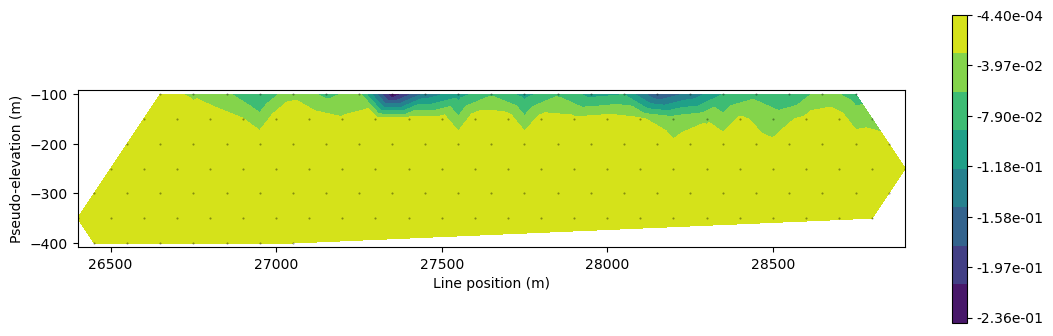

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
dc.utils.plot_pseudosection(
    dc_data, data_type="potential",
    plot_type="contourf", data_locations=True, ax=ax,
)
ax.set_aspect(1.5)

### 2.4. Process into apparent resistivity

We've loaded measurements data in units of volts above. Now we translate them into apparent resistivity.

See [this SimPEG notebook](https://github.com/simpeg/transform-2020-simpeg/blob/main/1-century-dcip-inversion.ipynb) for more details.

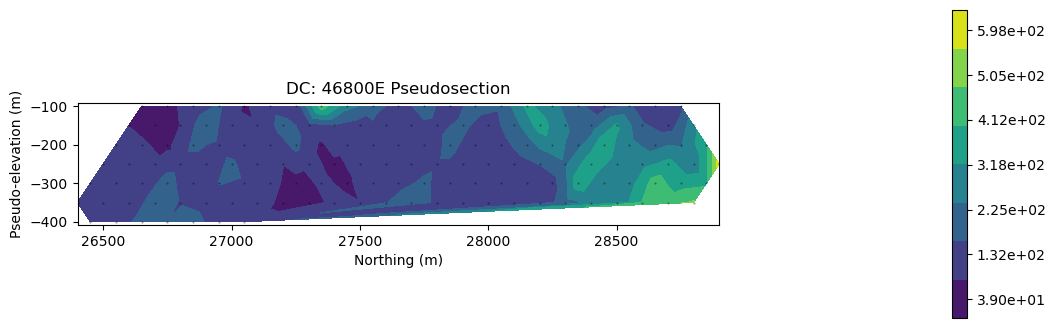

In [19]:
# plot psuedosection
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
dc.utils.plot_pseudosection(
    dc_data, data_type="apparent resistivity", 
    plot_type="contourf", data_locations=True, ax=ax, cbar_opts={"pad":0.25}
)
ax.set_aspect(1.5)  # some vertical exxageration
ax.set_title(f"DC: {line} Pseudosection")
ax.set_xlabel("Northing (m)");

In [20]:
apparent_resistivity = dc.utils.apparent_resistivity_from_voltage(dc_survey, dc_data.dobs)
apparent_resistivity_err = dc.utils.apparent_resistivity_from_voltage(dc_survey, dc_data.standard_deviation)
# apparent_resistivity_err = dc_data.standard_deviation
geometric_factor = dc.utils.geometric_factor(dc_survey)

In [21]:
apparent_resistivity_err

array([ 6.33351764,  6.33355107,  5.27791048,  5.27793137,  4.7501633 ,
        4.90090302,  4.61817167,  4.2223451 ,  9.50032661,  4.71239786,
        4.90090302,  4.61817167, 10.55586274,  7.91693884,  3.92071059,
        4.52390195,  4.52391048,  9.89608215,  7.38910392,  9.50032661,
        1.94150463,  2.56354154,  3.01593463,  6.40887317,  5.27791048,
        6.33351764,  6.33355107,  3.24212423,  4.07150715,  8.85930798,
        6.40887317,  7.91686572,  7.38910392,  6.33355107,  5.14592974,
       11.08354724,  7.16284475,  8.29383587,  7.91686572,  6.33351764,
        8.6519478 ,  5.4286762 ,  6.40886109,  6.40887317,  5.27791048,
        3.16675882,  3.44946938,  4.29770199,  4.90089378,  4.14691794,
        2.63895524,  2.11117255,  6.44654934,  9.80177647,  9.23629981,
        4.90090302,  4.61817167,  5.27793137,  4.59929251,  6.25805728,
        3.39292646,  3.01594032,  3.29869405,  4.2223451 , 22.24248018,
        7.7660229 ,  4.90089378,  4.90090302,  5.93764929,  7.38

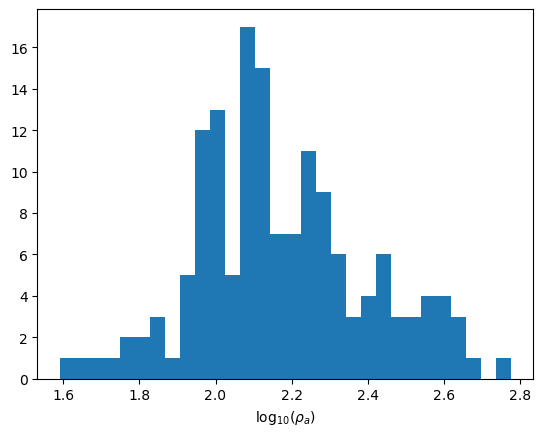

In [22]:
fig, ax = plt.subplots(1, 1)
out = ax.hist(np.log10(apparent_resistivity), bins=30)
ax.set_xlabel("log$_{10}(\\rho_a)$");

In [23]:
rho0 = np.median(apparent_resistivity)
rho0

135.90619481429147

In [24]:
len(apparent_resistivity)

151

In [25]:
apparent_resistivity[:10]

array([134.05945681, 126.67102145, 108.1971648 , 104.50304114,
        99.7534294 ,  95.00211999,  96.32186623,  92.89159212,
       197.92347102,  95.00194092])

## 3. Apparent Chargeability

### 3.1. Load chargeability data

In [26]:
ip_data_dict = read_dcip_data(ip_data_file)

number of sources: 27
Source 0: A-loc: 26000, B-loc: 26100, N receivers: 2
Source 1: A-loc: 26100, B-loc: 26200, N receivers: 3
Source 2: A-loc: 26200, B-loc: 26300, N receivers: 4
Source 3: A-loc: 26300, B-loc: 26400, N receivers: 5
Source 4: A-loc: 26400, B-loc: 26500, N receivers: 6
Source 5: A-loc: 26500, B-loc: 26600, N receivers: 7
Source 6: A-loc: 26600, B-loc: 26700, N receivers: 7
Source 7: A-loc: 26700, B-loc: 26800, N receivers: 6
Source 8: A-loc: 26800, B-loc: 26900, N receivers: 6
Source 9: A-loc: 26900, B-loc: 27000, N receivers: 6
Source 10: A-loc: 27000, B-loc: 27100, N receivers: 6
Source 11: A-loc: 27100, B-loc: 27200, N receivers: 6
Source 12: A-loc: 27200, B-loc: 27300, N receivers: 6
Source 13: A-loc: 27300, B-loc: 27400, N receivers: 6
Source 14: A-loc: 27400, B-loc: 27500, N receivers: 6
Source 15: A-loc: 27500, B-loc: 27600, N receivers: 6
Source 16: A-loc: 27600, B-loc: 27700, N receivers: 6
Source 17: A-loc: 27700, B-loc: 27800, N receivers: 6
Source 18: A-loc

### 3.2. See what's in chargeability data

In [27]:
for key, value in ip_data_dict.items():
    print(f"{key:<20}: {type(value)}")

a_locations         : <class 'numpy.ndarray'>
b_locations         : <class 'numpy.ndarray'>
m_locations         : <class 'list'>
n_locations         : <class 'list'>
observed_data       : <class 'list'>
standard_deviations : <class 'list'>
n_sources           : <class 'int'>


In [28]:
ip_data_dict["a_locations"]

array([26000., 26100., 26200., 26300., 26400., 26500., 26600., 26700.,
       26800., 26900., 27000., 27100., 27200., 27300., 27400., 27500.,
       27600., 27700., 27800., 27900., 28000., 28100., 28200., 28300.,
       28400., 28500., 28600.])

In [29]:
apparent_chargeability = np.hstack(ip_data_dict["observed_data"])
apparent_chargeability_err = np.hstack(ip_data_dict["standard_deviations"])

### 3.3. Create SimPEG Data and Survey

In [30]:
# initialize an empty list for each 
source_list_ip = []

for i in range(ip_data_dict["n_sources"]):
    
    # receiver electrode locations in 2D 
    m_locs = np.vstack([
        ip_data_dict["m_locations"][i], 
        np.zeros_like(ip_data_dict["m_locations"][i])
    ]).T
    n_locs = np.vstack([
        ip_data_dict["n_locations"][i],
        np.zeros_like(ip_data_dict["n_locations"][i])
    ]).T
    
    # construct the receiver object 
    receivers = ip.receivers.Dipole(
        locations_m=m_locs, locations_n=n_locs, data_type="apparent_chargeability"
    )
    
    # construct the source 
    source = ip.sources.Dipole(
        location_a=np.r_[ip_data_dict["a_locations"][i], 0.],
        location_b=np.r_[ip_data_dict["b_locations"][i], 0.],
        receiver_list=[receivers]
    )
    
    # append the new source to the source list
    source_list_ip.append(source)

In [31]:
survey_ip = ip.Survey(source_list_ip)

In [32]:
ip_data = Data(
    survey=dc_survey, 
    dobs=np.hstack(ip_data_dict["observed_data"]), 
    standard_deviation=np.hstack(ip_data_dict["standard_deviations"])
)

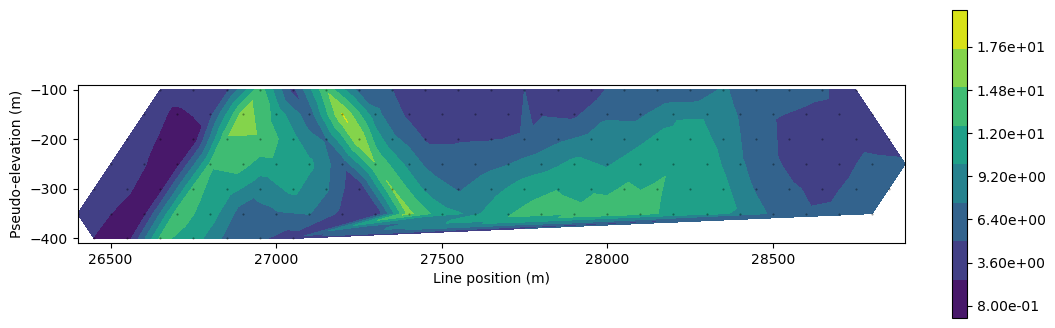

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
dc.utils.plot_pseudosection(
    ip_data, data_type="potential",
    plot_type="contourf", data_locations=True, ax=ax,
)
ax.set_aspect(1.5)

In [34]:
len(ip_data.dobs)

151

## 4. Write data to file

In [35]:
processed_data = np.zeros((len(apparent_resistivity), 9))
processed_data[:,4] = apparent_resistivity
processed_data[:,5] = apparent_resistivity_err
processed_data[:,6] = apparent_chargeability
processed_data[:,7] = apparent_chargeability_err
processed_data[:,8] = geometric_factor

data_idx = 0
for i in range(len(dc_data_dict["a_locations"])):
    a_loc = dc_data_dict["a_locations"][i]
    b_loc = dc_data_dict["b_locations"][i]
    m_locs = dc_data_dict["m_locations"][i]
    n_locs = dc_data_dict["n_locations"][i]
    for j in range(len(m_locs)):
        processed_data[data_idx,0] = a_loc
        processed_data[data_idx,1] = b_loc
        processed_data[data_idx,2] = m_locs[j]
        processed_data[data_idx,3] = n_locs[j]
        data_idx += 1

processed_data[:5]

array([[ 2.60000000e+04,  2.61000000e+04,  2.67000000e+04,
         2.68000000e+04,  1.34059457e+02,  6.33351764e+00,
         4.30000000e+00,  3.00000000e-01, -9.47350852e-06],
       [ 2.60000000e+04,  2.61000000e+04,  2.68000000e+04,
         2.69000000e+04,  1.26671021e+02,  6.33355107e+00,
         2.40000000e+00,  3.00000000e-01, -6.31567234e-06],
       [ 2.61000000e+04,  2.62000000e+04,  2.67000000e+04,
         2.68000000e+04,  1.08197165e+02,  5.27791048e+00,
         4.30000000e+00,  3.00000000e-01, -1.51576136e-05],
       [ 2.61000000e+04,  2.62000000e+04,  2.68000000e+04,
         2.69000000e+04,  1.04503041e+02,  5.27793137e+00,
         2.50000000e+00,  3.00000000e-01, -9.47350852e-06],
       [ 2.61000000e+04,  2.62000000e+04,  2.69000000e+04,
         2.70000000e+04,  9.97534294e+01,  4.75016330e+00,
         1.00000000e+00,  3.00000000e-01, -6.31567234e-06]])

In [36]:
np.savetxt(
    "../century_dcip_data.txt", 
    processed_data, 
    header="# a_loc, b_loc, m_loc, n_loc, apparent_resistivity, apparent_resistivity_err, apparent_chargeability, apparent_chargeability_err, geometric_factor"
)

## 5. Convert mesh and model files format

In [37]:
import discretize

In [38]:
dc_model_file = f"./century/{line}/DCMODA.CON"
ip_model_file = f"./century/{line}/IPMODA.CHG"
mesh_file = f"./century/{line}/{line[:3]}MESH.DAT"

mesh_file, dc_model_file, ip_model_file

('./century/46800E/468MESH.DAT',
 './century/46800E/DCMODA.CON',
 './century/46800E/IPMODA.CHG')

In [39]:
mesh_ubc = discretize.TensorMesh.read_UBC(mesh_file)
mesh_tensor = mesh_ubc.get_tensor("nodes")
np.savetxt("../century_mesh_nodes_x.txt", mesh_tensor[0])
np.savetxt("../century_mesh_nodes_z.txt", mesh_tensor[1])

In [40]:
def read_ubc_model(filename, mesh_ubc=mesh_ubc): 
    """
    A function to read a UBC conductivity or chargeability model. 
    """
    values = np.genfromtxt(
        filename, delimiter=' \n',
        dtype=str, comments='!', skip_header=1
    )
    tmp = np.hstack([np.array(value.split(), dtype=float) for value in values])
    model_ubc = discretize.utils.mkvc(tmp.reshape(mesh_ubc.vnC, order='F')[:,::-1])
    return model_ubc

# DC
sigma_ubc = read_ubc_model(dc_model_file)
rho_ubc = 1./sigma_ubc
np.savetxt("../century_dc_model.txt", rho_ubc)

# IP
charge_ubc = read_ubc_model(ip_model_file)
np.savetxt("../century_ip_model.txt", charge_ubc)

---

## Watermark

In [41]:
import SimPEG
SimPEG.__version__

'0.19.0'